In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.fft import fft2, fftshift
from scipy.interpolate import interp1d

In [2]:
thicknesses = np.array([500, 600, 400, 500])       
velocities = np.array([2.5, 3, 3.5, 3, 4]) * 1e3      
densities = np.array([2.2, 2.4, 2.5, 2.4, 2.6]) * 1e3  
depths = np.concatenate(([0], np.cumsum(thicknesses)))

velocity_profile = np.hstack([np.full(t, velocities[i]) for i, t in enumerate(thicknesses)])
density_profile = np.hstack([np.full(t, densities[i]) for i, t in enumerate(thicknesses)])

Deep = np.linspace(0, depths[-1], int(np.sum(thicknesses)))

f_vel = interp1d(depths, velocities, kind='nearest', fill_value="extrapolate")
f_den = interp1d(depths, densities, kind='nearest', fill_value="extrapolate")
velocity = f_vel(Deep)
density = f_den(Deep)

acoustic_impedance = velocity * density

In [3]:
Reflectivity = np.diff(acoustic_impedance) / (acoustic_impedance[:-1] + acoustic_impedance[1:])
fs_wavelet = 1000                   
t_wavelet = np.linspace(-0.5, 0.5, fs_wavelet)
f0 = 60                    
wavelet = (1 - 2 * (np.pi * f0 * t_wavelet)**2) * np.exp(-(np.pi * f0 * t_wavelet)**2)
wavelet /= np.max(np.abs(wavelet))  
convolved_signal = convolve(Reflectivity, wavelet, mode='same')

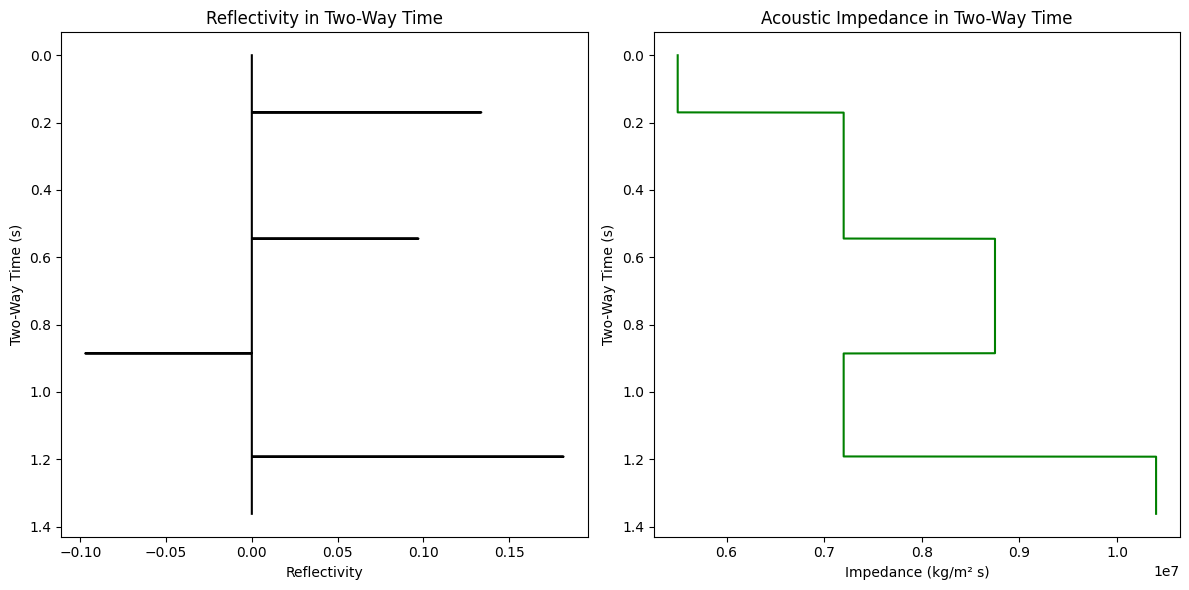

In [4]:
dt = 0.004
twt = np.cumsum(np.concatenate(([0], 2 * thicknesses / velocities[:-1])))
t_R = np.linspace(0, twt[-1], len(Reflectivity))
t_imp = np.linspace(0, twt[-1], len(acoustic_impedance))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(Reflectivity, t_R, color='black')
axs[0].set_title('Reflectivity in Two-Way Time')
axs[0].set_xlabel('Reflectivity')
axs[0].set_ylabel('Two-Way Time (s)')
axs[0].invert_yaxis()

axs[1].plot(acoustic_impedance, t_imp, color='green')
axs[1].set_title('Acoustic Impedance in Two-Way Time')
axs[1].set_xlabel('Impedance (kg/m² s)')
axs[1].set_ylabel('Two-Way Time (s)')
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

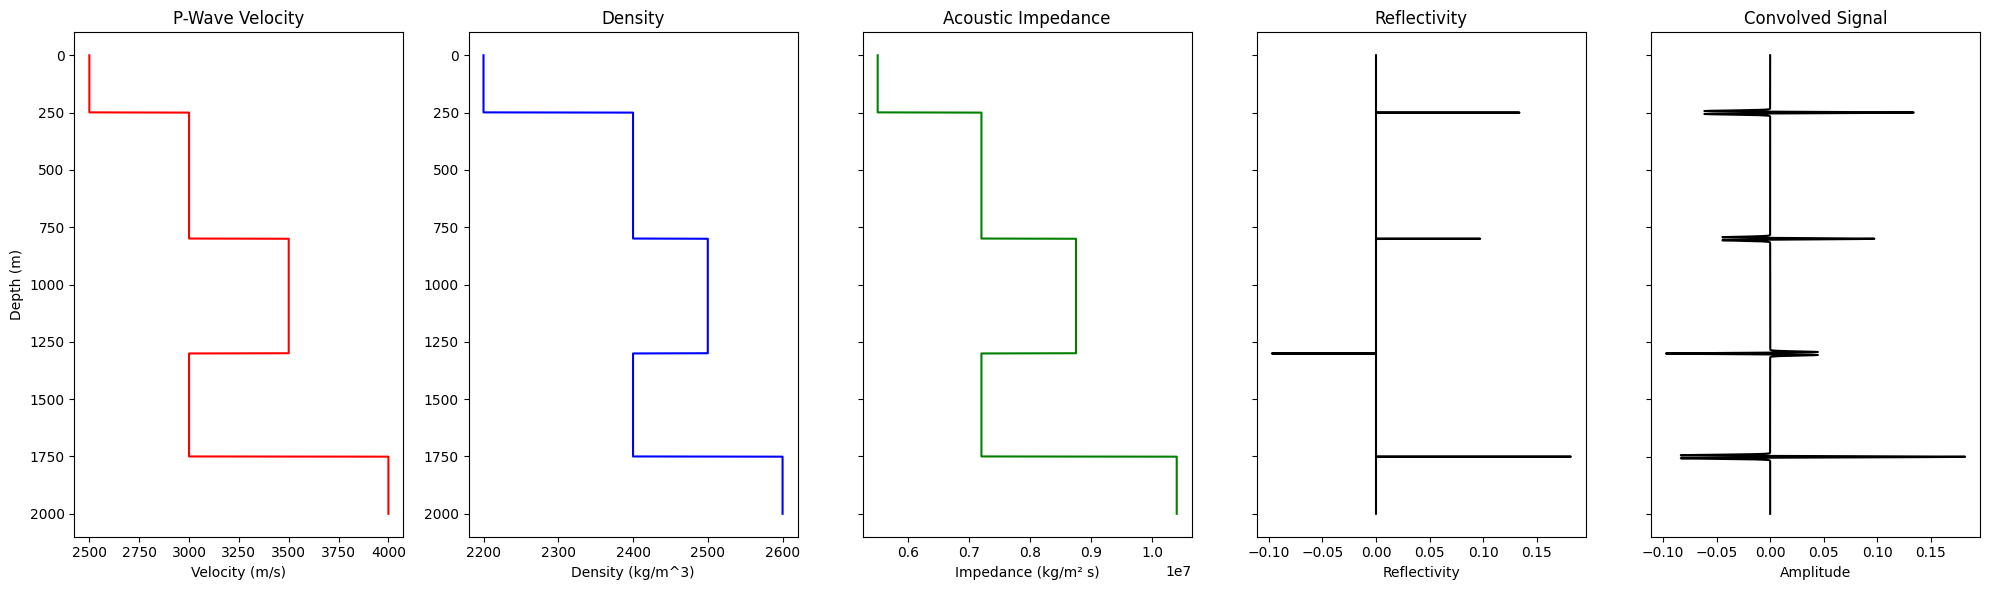

In [5]:

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].plot(velocity, Deep, color='red')
axs[0].set_title('P-Wave Velocity')
axs[0].set_xlabel('Velocity (m/s)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

axs[1].plot(density, Deep, color='blue')
axs[1].set_title('Density')
axs[1].set_xlabel('Density (kg/m^3)')
axs[1].invert_yaxis()

axs[2].plot(acoustic_impedance, Deep, color='green')
axs[2].set_title('Acoustic Impedance')
axs[2].set_xlabel('Impedance (kg/m² s)')
axs[2].invert_yaxis()
axs[2].set_yticklabels([])

axs[3].plot(np.concatenate(([0], Reflectivity)), np.concatenate(([0], Deep[1:])), color='black')
axs[3].set_title('Reflectivity')
axs[3].set_xlabel('Reflectivity')
axs[3].invert_yaxis()
axs[3].set_yticklabels([])

axs[4].plot(convolved_signal, Deep[:len(convolved_signal)], color='black')
axs[4].set_title('Convolved Signal')
axs[4].set_xlabel('Amplitude')
axs[4].invert_yaxis()
axs[4].set_yticklabels([])

plt.tight_layout()
plt.show()

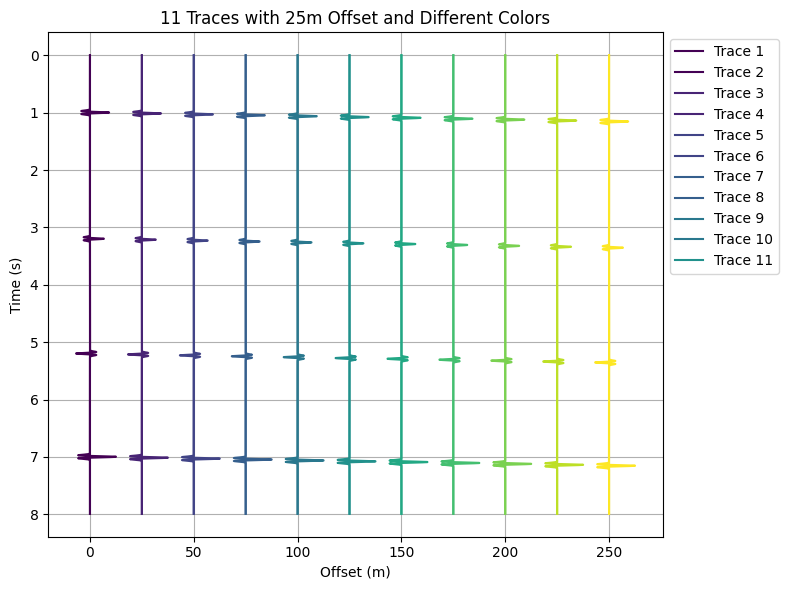

In [6]:
max_offset = 2000 
trace_interval = 25  
num_traces = int(np.floor(max_offset / trace_interval) + 1)
sample_interval = 0.004 
seismic_section = np.zeros((len(convolved_signal), num_traces))
mean_velocity = np.mean(velocities)
for i in range(num_traces):
    offset = i * trace_interval
    travel_time = offset / mean_velocity  
    shift_samples = int(round(travel_time / sample_interval))
    seismic_section[:, i] = np.roll(convolved_signal, shift_samples)
num_traces = 11  
colors = plt.cm.viridis(np.linspace(0, 1, num_traces))
time_vector = np.arange(len(convolved_signal)) * sample_interval

plt.figure(figsize=(8, 6))
for i in range(num_traces):
    offset = i * trace_interval
    travel_time = 2 * offset / mean_velocity 
    shift_samples = int(round(travel_time / sample_interval))
    shifted_signal = np.roll(convolved_signal, shift_samples)
    plt.plot(offset + np.zeros_like(shifted_signal), time_vector, color=colors[i], linewidth=1.5)
    plt.plot(offset + shifted_signal / np.max(np.abs(shifted_signal)) * trace_interval / 2,
             time_vector, color=colors[i], linewidth=1.5)

plt.xlabel('Offset (m)')
plt.ylabel('Time (s)')
plt.title('11 Traces with 25m Offset and Different Colors')
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend([f"Trace {i+1}" for i in range(num_traces)], loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

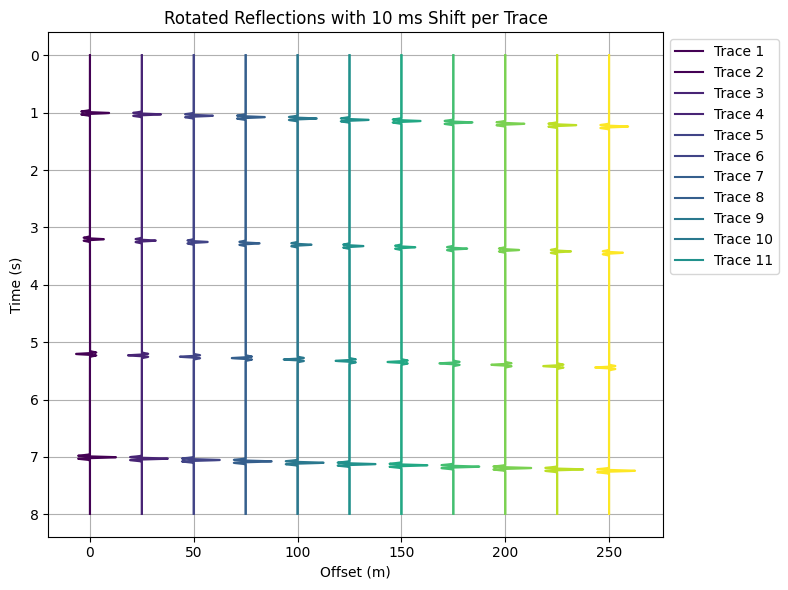

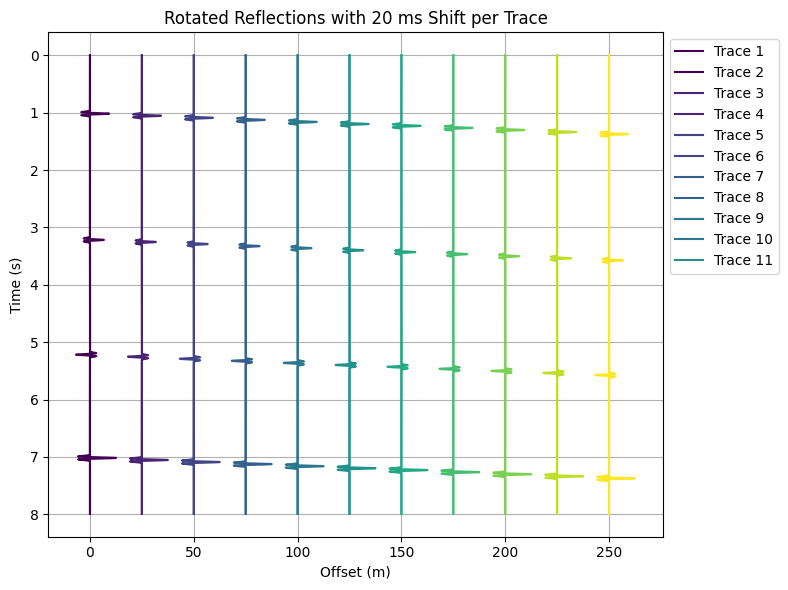

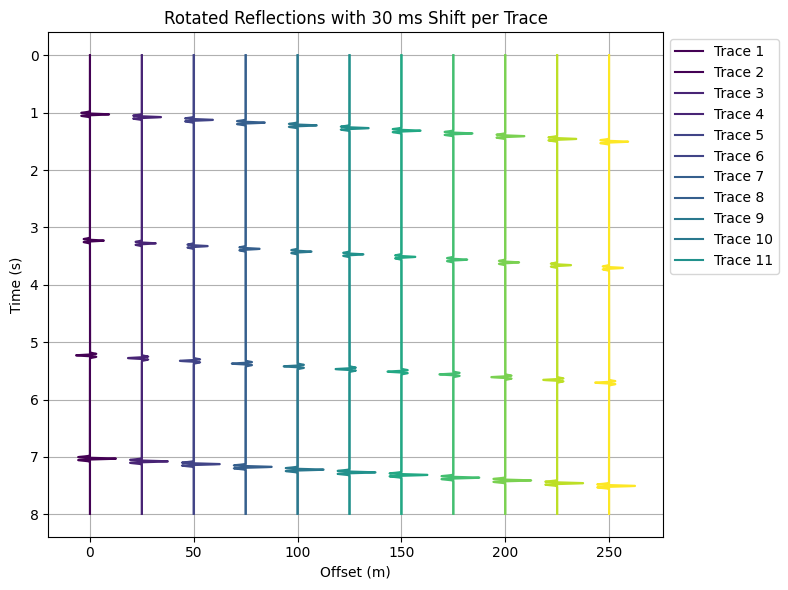

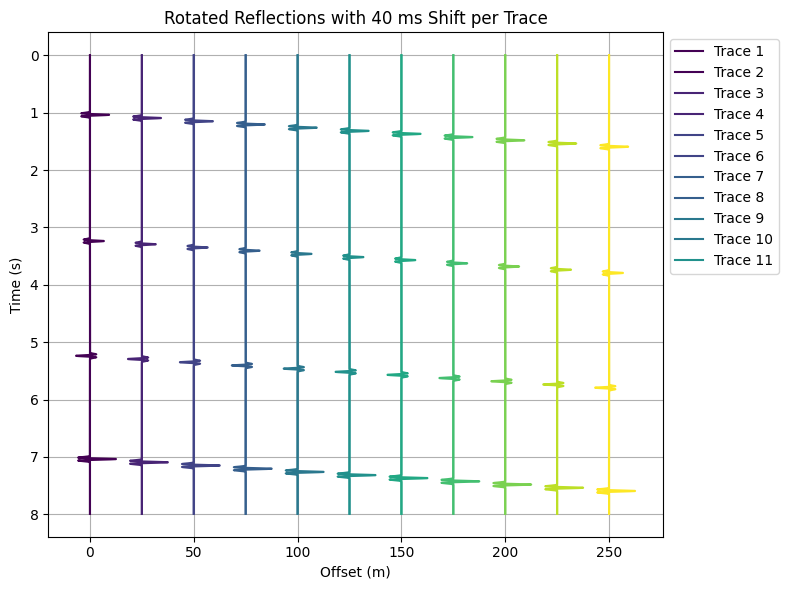

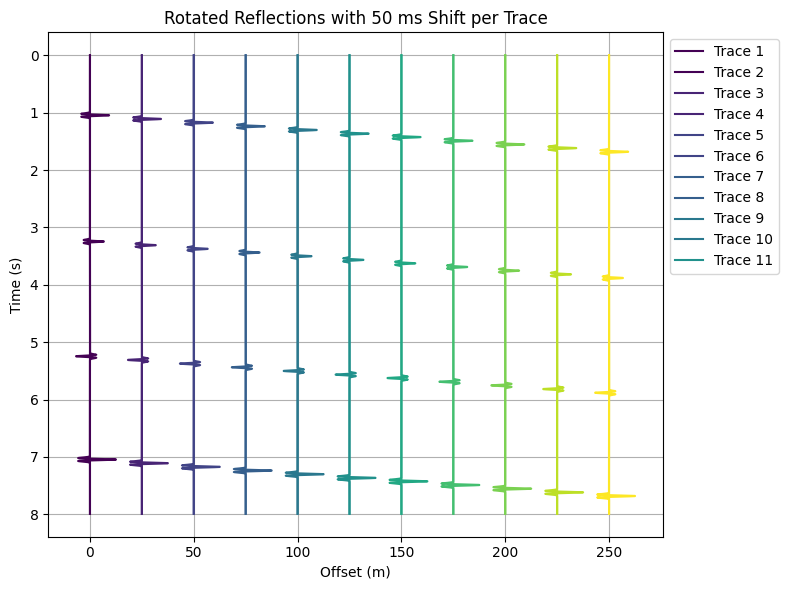

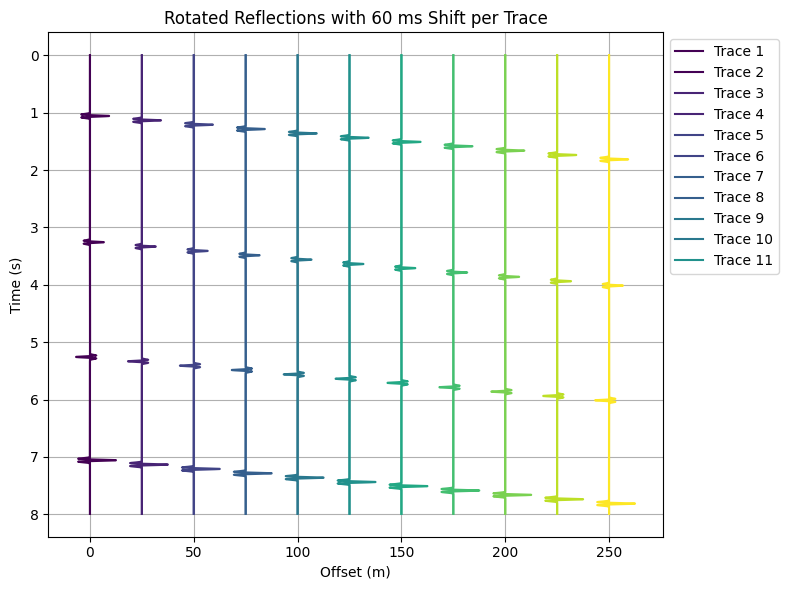

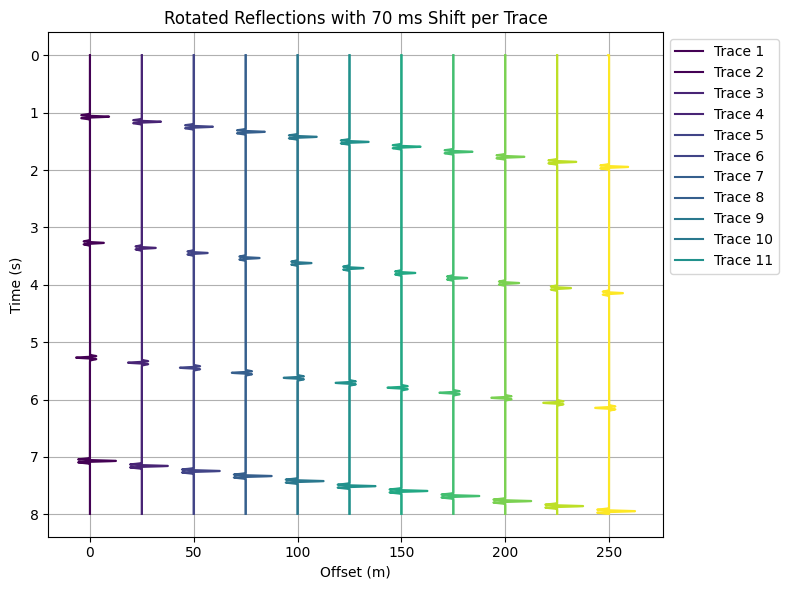

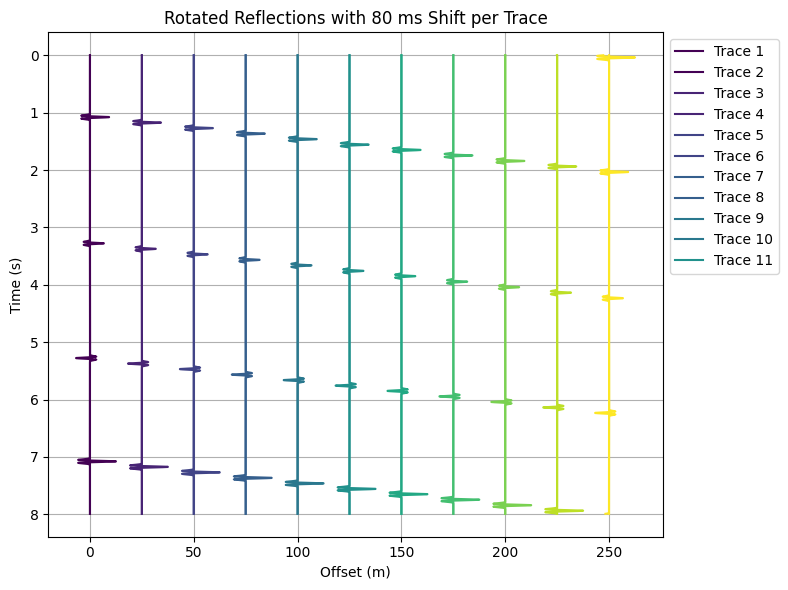

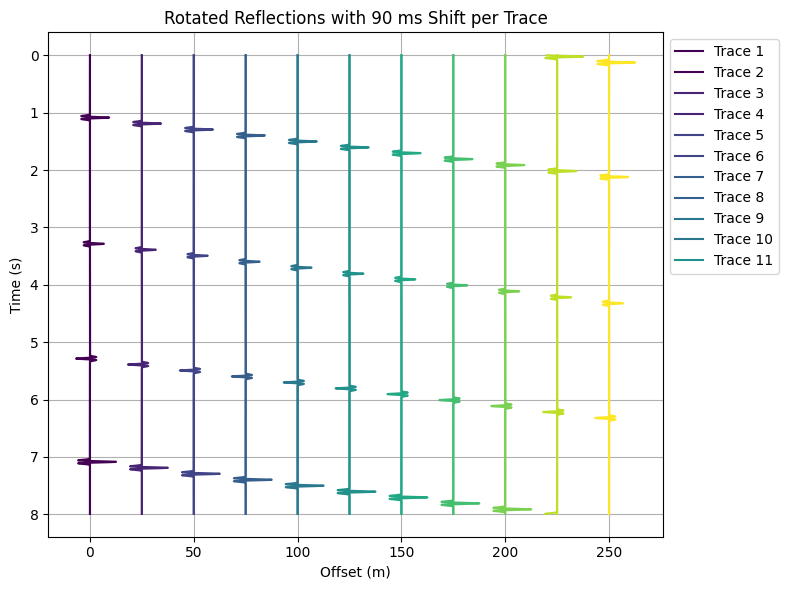

In [7]:
time_shifts_ms = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
time_shifts_samples = np.round(time_shifts_ms / 1000 / sample_interval).astype(int)

for idx, base_shift in enumerate(time_shifts_samples):
    plt.figure(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, num_traces))
    for i in range(num_traces):
        offset = i * trace_interval
        travel_time = 2 * offset / mean_velocity
        shift_samples = int(round(travel_time / sample_interval))
        shifted_signal = np.roll(convolved_signal, shift_samples)
        rotated_shift = base_shift * (i + 1)
        rotated_signal = np.roll(shifted_signal, rotated_shift)
        
        plt.plot(offset + np.zeros_like(rotated_signal), time_vector, color=colors[i], linewidth=1.5)
        plt.plot(offset + rotated_signal / np.max(np.abs(rotated_signal)) * trace_interval / 2,
                 time_vector, color=colors[i], linewidth=1.5)
    
    plt.xlabel('Offset (m)')
    plt.ylabel('Time (s)')
    plt.title(f'Rotated Reflections with {time_shifts_ms[idx]} ms Shift per Trace')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend([f"Trace {i+1}" for i in range(num_traces)], loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

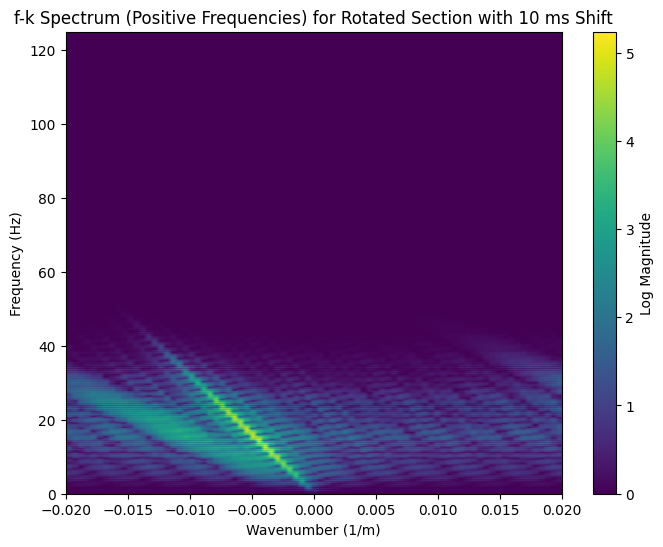

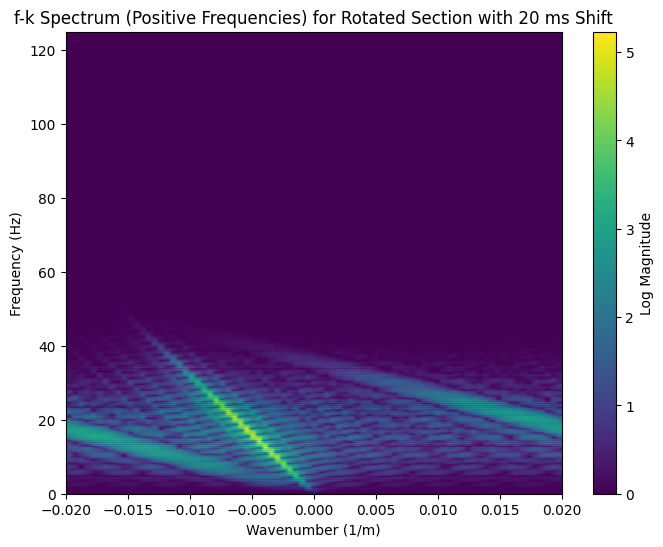

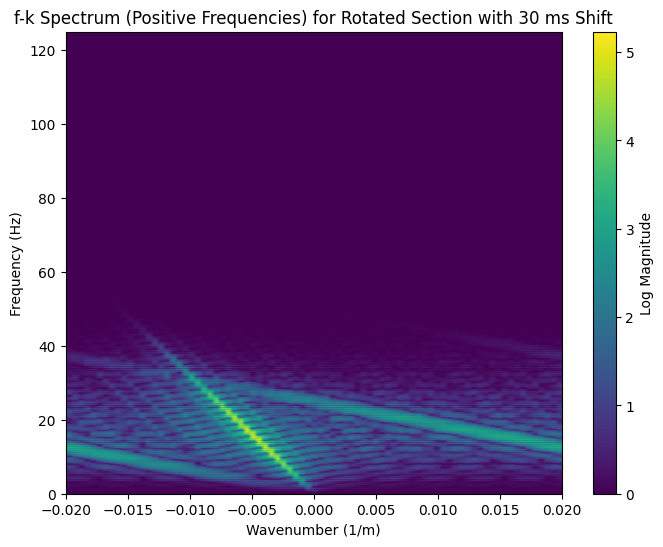

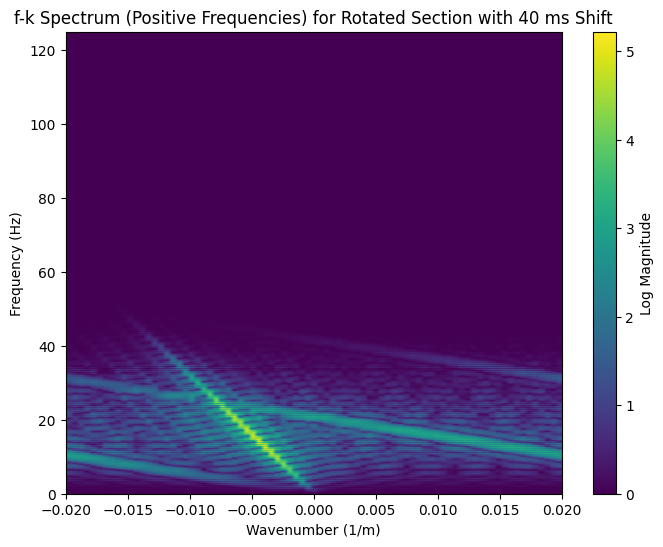

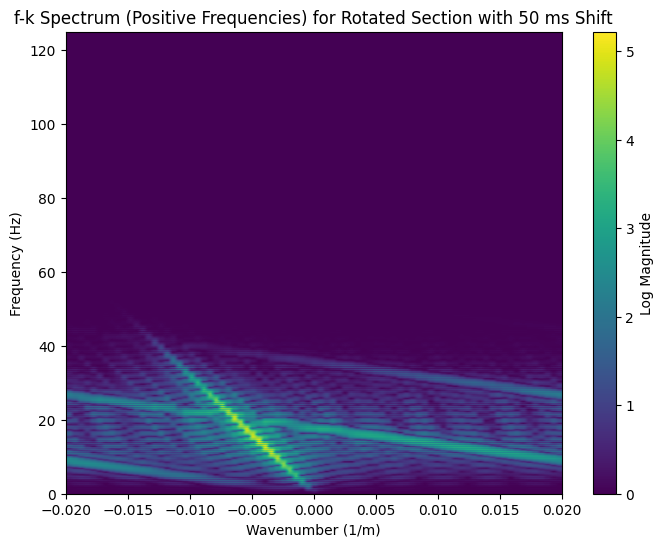

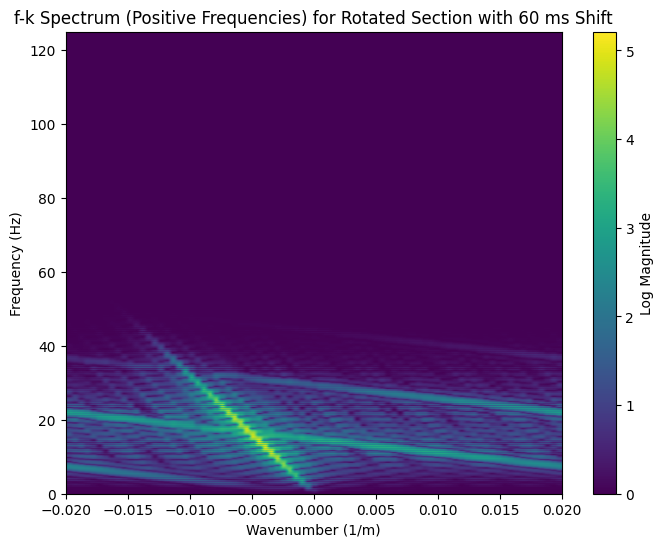

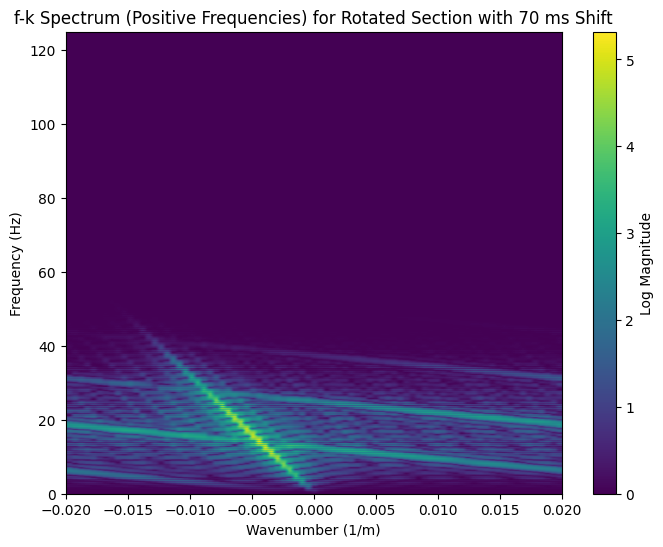

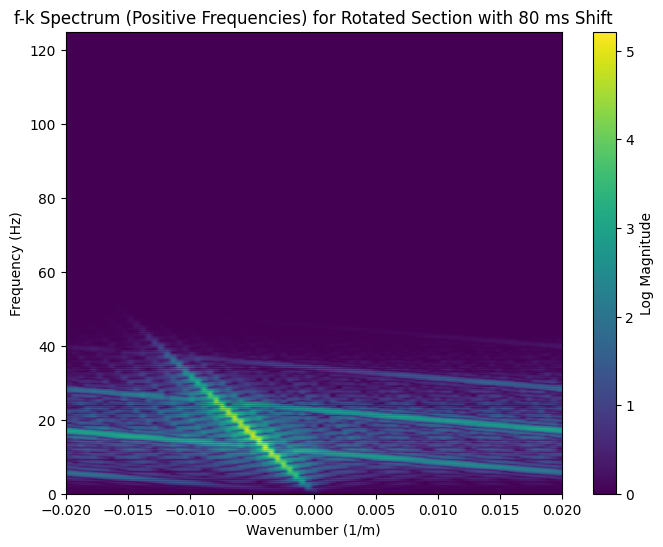

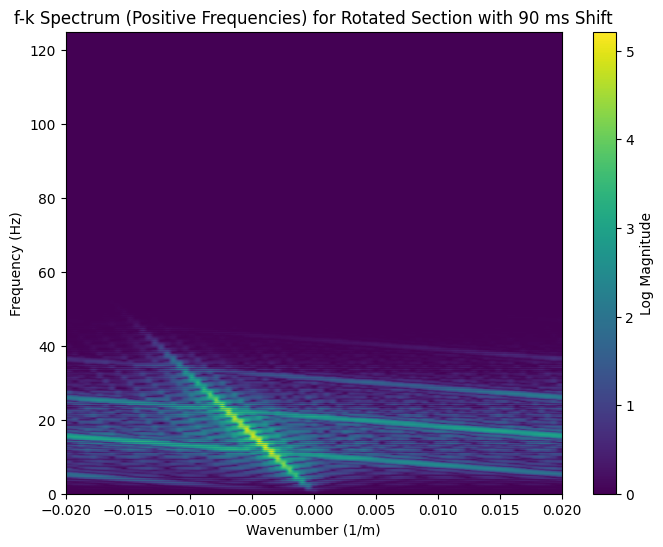

In [8]:
dx = trace_interval
fs_fk = 1 / sample_interval

for idx, base_shift in enumerate(time_shifts_samples):
    rotated_section = seismic_section.copy()
    for i in range(num_traces):
        rotated_section[:, i] = np.roll(seismic_section[:, i], base_shift * (i + 1))
    
    F_K = fftshift(np.abs(fft2(rotated_section)))
    
    N_time = rotated_section.shape[0]
    f_axis_full = np.linspace(-fs_fk/2, fs_fk/2, N_time) 
    f_axis_positive = np.linspace(0, fs_fk/2, N_time // 2)  
    k_axis = np.linspace(-1/(2*dx), 1/(2*dx), num_traces)

    F_K_positive = F_K[N_time//2:, :]  
    
    plt.figure(figsize=(8, 6))
    plt.imshow(np.log(1 + F_K_positive), extent=[k_axis[0], k_axis[-1], f_axis_positive[0], f_axis_positive[-1]],
               aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Log Magnitude')
    plt.xlabel('Wavenumber (1/m)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'f-k Spectrum (Positive Frequencies) for Rotated Section with {time_shifts_ms[idx]} ms Shift')
    plt.show()